<a href="https://colab.research.google.com/github/clayedw/RET-2024/blob/main/gaussian_binning_with_a_bunch_of_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#The code below is based off that of LSSTDESC/CCLX and uses that of:
#  Niko Sarcevic
#  nikolina.sarcevic@gmail.com
#  github.com/nikosarcevic
#and
#  Andrina Nicola
#  anicola[at]astro[dot]princeton[dot]edu
#  github.com/Andrina Nicola
#and
#  Elisa Chisari
#  n.e.chisari@uu.nl
#  #  github.com/elisachisari
!pip install -q condacolab
import condacolab

condacolab.install()

!conda install --no-pin pyccl

import pyccl as ccl

✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
Platform: linux-64
Solving environment: \ | / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



#Tomographic binning of redshift distributions according to Gaussian distributions

This project focuses on analyzing galaxy data across different redshift bins to understand their spatial clustering properties.

The project begins by defining a range of redshift values and characterizing the distribution of galaxies using a Smail-type parameterization. This distribution model helps to approximate how galaxies are distributed across different redshifts, influenced by parameters like α and β.

Next, the redshift data is divided into bins defined by specific bin edges. Each bin represents a range of redshift values within which galaxies are categorized. Photometric redshift uncertainties (σ) are also considered, reflecting measurement errors in determining the precise redshift of galaxies.

Galaxy data is binned according to their Gaussian distributions. Each galaxy's contribution to the distribution curve within a bin is determined by integrating the Gaussian probability density function over the bin's range. This distributes galaxy data points across bins, accounting for uncertainties in their redshift measurements.

With normalization, the total contribution of galaxy data points across all bins sums to one.

An accuracy metric was implemented to compare the power spectra of the binned distribution to the analytic distribution, normalized by the cosmic variance errors.

Further analysis includes calculating angular power spectra and correlation functions for each redshift bin. These analyses provide insights into the spatial clustering of galaxies at different redshifts, and galaxy clustering evolution over cosmic time.

Overall, the project combines theoretical modeling of redshift distributions with observational data analysis techniques to analyze galaxy clustering in the universe, accounting for uncertainties in redshift measurements to hopefully derive meaningful cosmological insights.

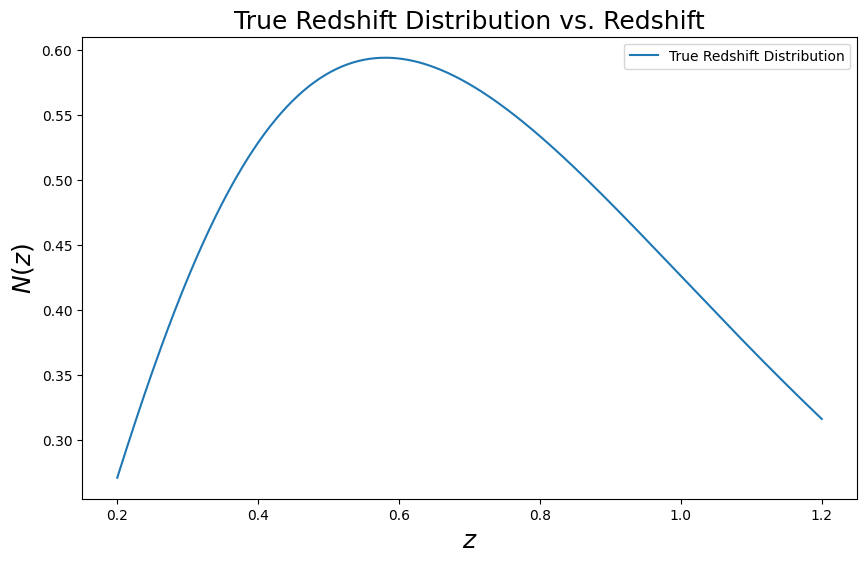

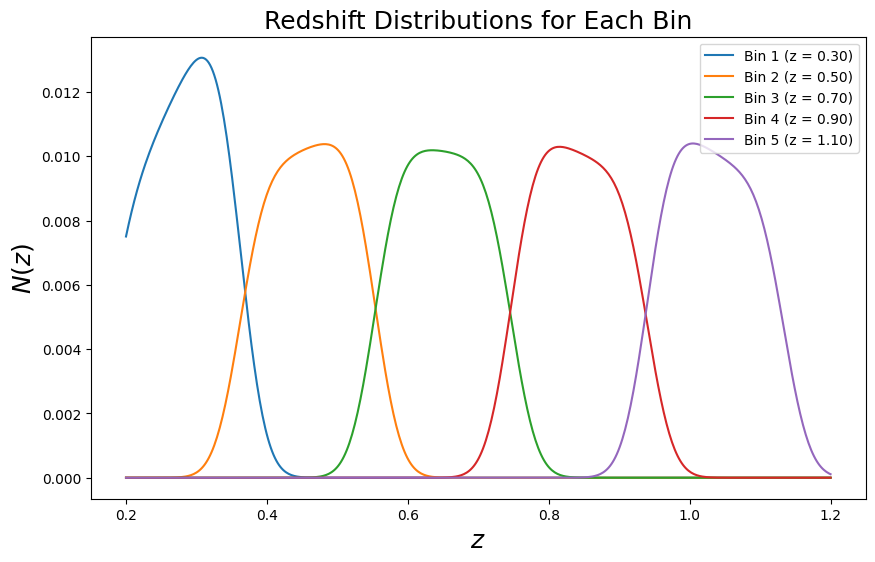

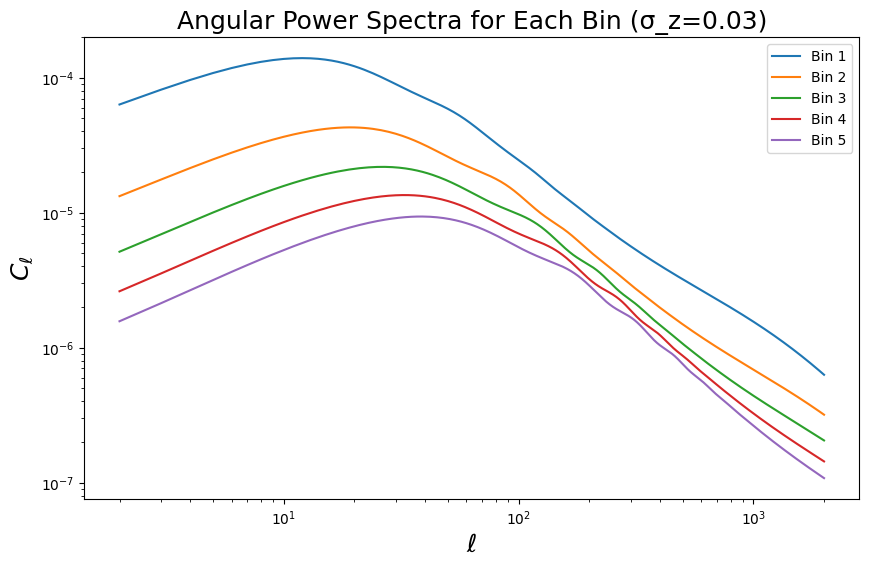

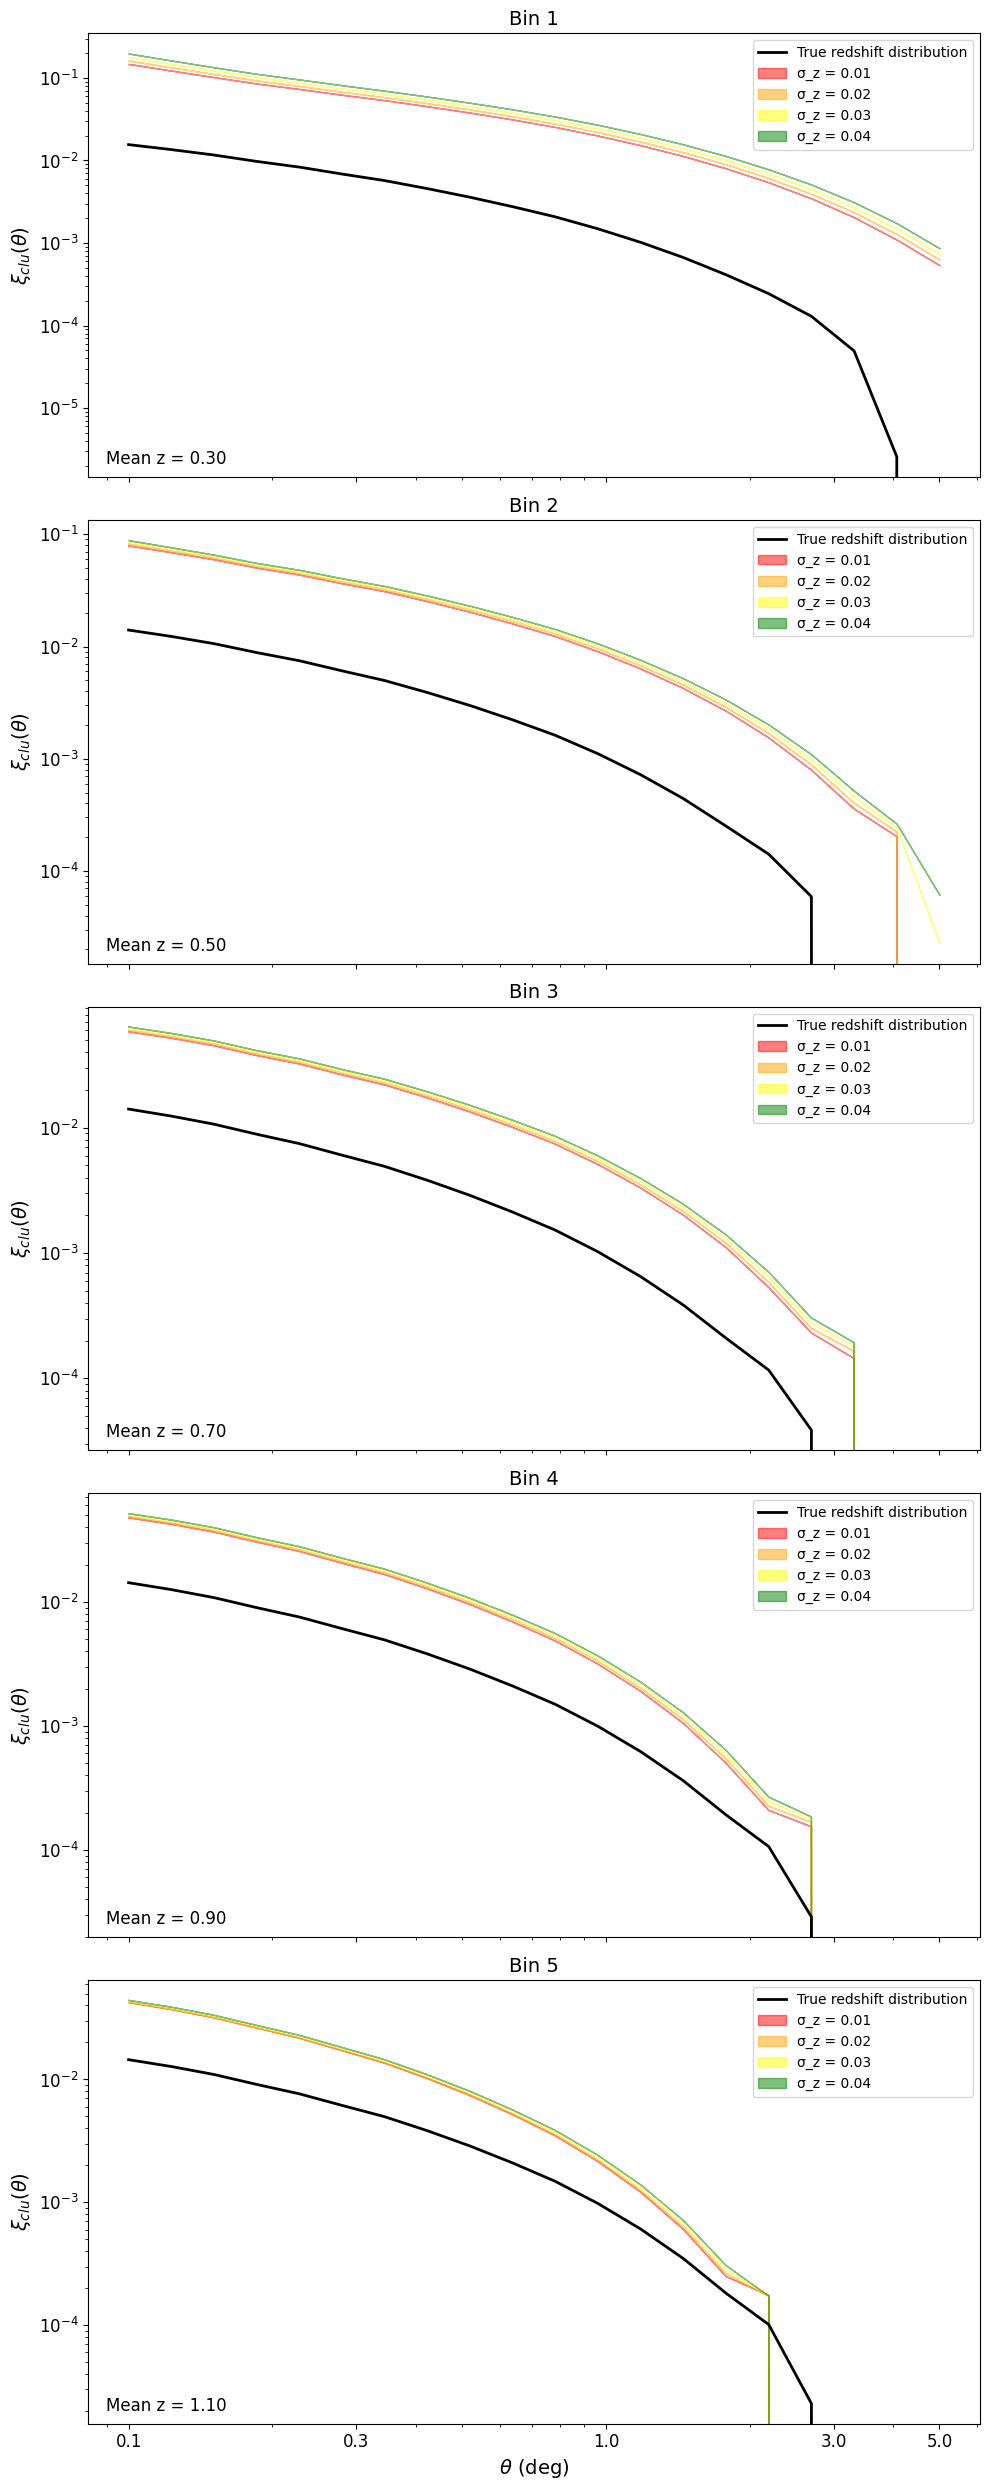

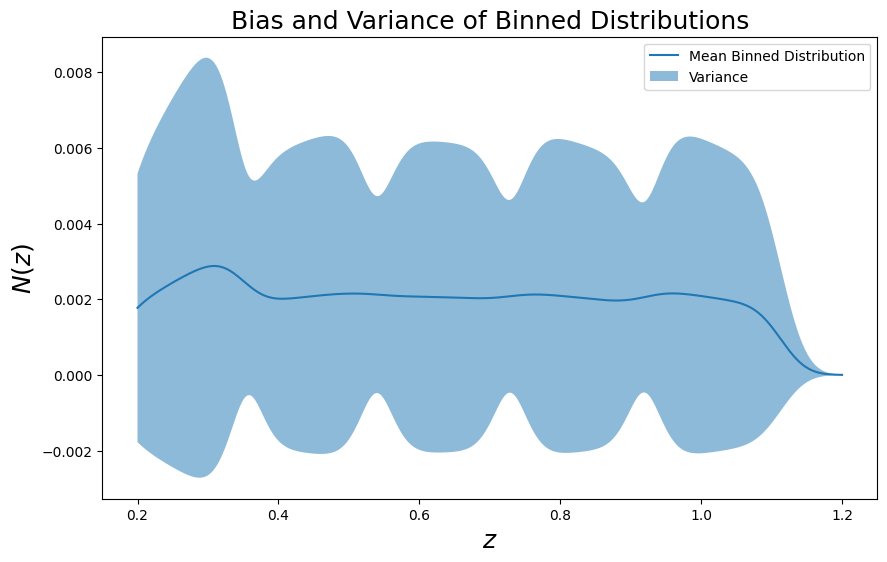

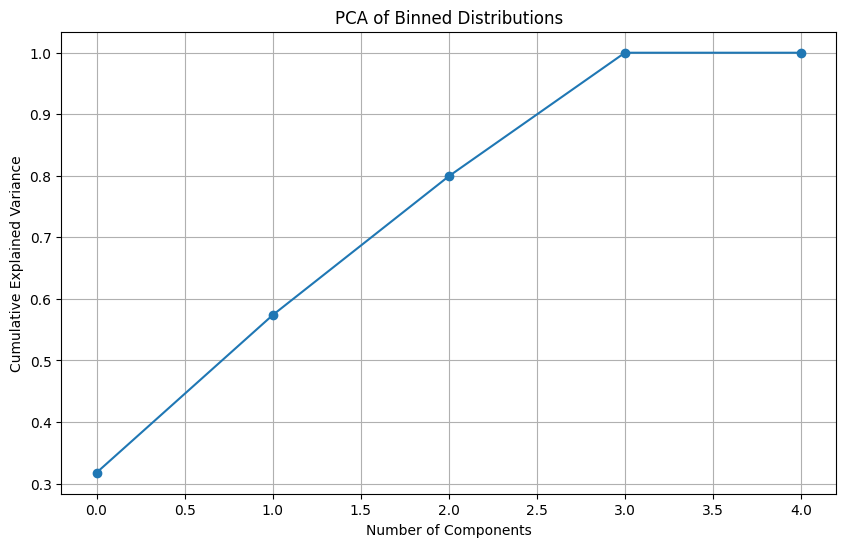

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import scipy.stats as stats
from sklearn.decomposition import PCA

class SRDRedshiftDistributions:
    def __init__(self, redshift_range):
        self.redshift_range = redshift_range

    def smail_type_distribution(self, pivot_redshift, alpha, beta):
        redshift_distribution = [(z / pivot_redshift) ** beta * np.exp(-(z / pivot_redshift) ** alpha) for z in self.redshift_range]
        return np.array(redshift_distribution)

class RedshiftBinning:
    def __init__(self, redshifts, redshift_dist, bin_edges, uncertainties):
        self.redshifts = redshifts
        self.redshift_dist = redshift_dist
        self.bin_edges = bin_edges
        self.uncertainties = uncertainties
        self.binned_distribution = np.zeros((len(bin_edges) - 1, len(redshifts)))

    def gaussian_contribution(self, z_i, sigma, bin_edge1, bin_edge2):
        norm_factor = 1 / (sigma * np.sqrt(2 * np.pi))
        integrand = lambda x: norm_factor * np.exp(-0.5 * ((x - z_i) / sigma) ** 2)
        contribution, _ = quad(integrand, bin_edge1, bin_edge2)
        return contribution

    def bin_data(self, scatter):
        for i, z in enumerate(self.redshifts):
            for j in range(len(self.bin_edges) - 1):
                bin_edge1 = self.bin_edges[j]
                bin_edge2 = self.bin_edges[j + 1]
                z_scattered = z + scatter[i]
                self.binned_distribution[j, i] = self.redshift_dist[i] * self.gaussian_contribution(z_scattered, self.uncertainties[i], bin_edge1, bin_edge2)

        # Normalize the binned distribution
        for j in range(len(self.bin_edges) - 1):
            self.binned_distribution[j, :] /= np.sum(self.binned_distribution[j, :])

# Define cosmological parameters
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)

# Define redshift range and distribution parameters
redshift_range = np.linspace(0.2, 1.2, 512)
beta = 2.0
alpha = 0.94
pivot_redshift = 0.26

# Instantiate SRDRedshiftDistributions and get redshift distribution
srd = SRDRedshiftDistributions(redshift_range)
redshift_distribution = srd.smail_type_distribution(pivot_redshift, alpha, beta)

# Plot the true redshift distribution
plt.figure(figsize=(10, 6))
plt.plot(redshift_range, redshift_distribution, label='True Redshift Distribution')
plt.xlabel('$z$', fontsize=18)
plt.ylabel('$N(z)$', fontsize=18)
plt.title('True Redshift Distribution vs. Redshift', fontsize=18)
plt.legend()
plt.show()

# Define bin edges and sigma (uncertainty)
bin_edges = np.linspace(0.2, 1.2, 6)
sigma_z = 0.03
sigma = sigma_z * np.ones_like(redshift_range)  # Photometric redshift uncertainty

# Compute scatter as defined
scatter = sigma_z * (1 + redshift_range)

# Instantiate RedshiftBinning and bin the data
binning = RedshiftBinning(redshift_range, redshift_distribution, bin_edges, sigma)
binning.bin_data(scatter)

# Plot the redshift distributions for each bin
plt.figure(figsize=(10, 6))
for j in range(len(bin_edges) - 1):
    bin_center = 0.5 * (bin_edges[j] + bin_edges[j + 1])
    plt.plot(redshift_range, binning.binned_distribution[j], label=f'Bin {j+1} (z = {bin_center:.2f})')

plt.xlabel('$z$', fontsize=18)
plt.ylabel('$N(z)$', fontsize=18)
plt.title('Redshift Distributions for Each Bin', fontsize=18)
plt.legend()
plt.show()

# Create NumberCountsTracers for each bin using the binned redshift distribution
tracers = []
for i in range(len(bin_edges) - 1):
    z_bin = redshift_range
    dNdz_bin = binning.binned_distribution[i]
    tracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_bin, dNdz_bin), bias=(z_bin, 1.5 * np.ones_like(z_bin)))
    tracers.append(tracer)

# Specify angular multipoles
ell = np.arange(2, 2000)

# Calculate angular power spectra
cls = []
for tracer in tracers:
    cls.append(ccl.angular_cl(cosmo, tracer, tracer, ell))

# Plot angular power spectra
plt.figure(figsize=(10, 6))
for i, cl in enumerate(cls):
    plt.plot(ell, cl, label=f'Bin {i+1}')
plt.xlabel('$\\ell$', fontsize=18)
plt.ylabel('$C_\\ell$', fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title(f'Angular Power Spectra for Each Bin (σ_z={sigma_z})', fontsize=18)
plt.show()

# Compute the true redshift distribution (no photo-z uncertainty)
true_lens_redshift_distribution_dict = {}
for index, (x1, x2) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
    mean_z_bin = (x1 + x2) / 2
    true_lens_redshift_distribution_dict[index] = srd.smail_type_distribution(mean_z_bin, alpha, beta)

# Create the NumberCountsTracer objects for each bin with true redshift distribution
true_tracers = []
for i in range(len(bin_edges) - 1):
    z_bin = redshift_range
    dNdz = true_lens_redshift_distribution_dict[i]
    tracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_bin, dNdz), bias=(z_bin, 1.5 * np.ones_like(z_bin)))
    true_tracers.append(tracer)

# Calculate the angular power spectra for each bin (auto-correlations) with true redshift distribution
true_cls_matrix = np.zeros((len(bin_edges) - 1, len(ell)))
for i in range(len(bin_edges) - 1):
    true_cls_matrix[i] = ccl.angular_cl(cosmo, true_tracers[i], true_tracers[i], ell)

# Define angular scales in degrees
theta_deg = np.logspace(-1, np.log10(5.), 20)

# Calculate the correlation function for each bin with true redshift distribution
true_correlations_matrix = np.zeros((len(bin_edges) - 1, len(theta_deg)))
for i in range(len(bin_edges) - 1):
    true_cls = true_cls_matrix[i]
    true_correlations_matrix[i] = ccl.correlation(cosmo, ell=ell, C_ell=true_cls, theta=theta_deg, type='NN', method='FFTLog')

# Plot the auto-correlations for different photo-z uncertainties
fig, axs = plt.subplots(len(bin_edges) - 1, 1, figsize=(10, (len(bin_edges) - 1) * 5), sharex=True)
if len(bin_edges) - 1 == 1:
    axs = [axs]  # Ensure axs is iterable when there's only one subplot

# Define colors for plotting different photo-z uncertainties
colors = ['red', 'orange', 'yellow', 'green']

# Example sigma_values
sigma_values = [0.01, 0.02, 0.03, 0.04]

# Simulate correlations for different sigma_z values
correlations = []
for sigma_val in sigma_values:
    # Assuming we need to compute the correlation functions for these sigma_z values
    scatter = sigma_val * (1 + redshift_range)
    binning.bin_data(scatter)
    correlation_matrix = np.zeros((len(bin_edges) - 1, len(theta_deg)))
    for i in range(len(bin_edges) - 1):
        dNdz_bin = binning.binned_distribution[i]
        tracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(redshift_range, dNdz_bin), bias=(redshift_range, 1.5 * np.ones_like(redshift_range)))
        cls_sigma = ccl.angular_cl(cosmo, tracer, tracer, ell)
        correlation_matrix[i] = ccl.correlation(cosmo, ell=ell, C_ell=cls_sigma, theta=theta_deg, type='NN', method='FFTLog')
    correlations.append(correlation_matrix)

for i in range(len(bin_edges) - 1):
    mean_z = 0.5 * (bin_edges[i] + bin_edges[i + 1])

    # Plot the true redshift distribution correlation
    xi_clu_true = true_correlations_matrix[i]
    axs[i].plot(theta_deg, xi_clu_true, color='black', label='True redshift distribution', linewidth=2)

    # Plot the shaded regions for each photo-z uncertainty using sigma_values and correlations
    for j, sigma_z in enumerate(sigma_values):
        xi_clu = correlations[j][i]

        # Calculate the upper and lower bounds
        lower_bound = np.maximum(0, xi_clu_true - (xi_clu_true - xi_clu))
        upper_bound = xi_clu_true + (xi_clu - xi_clu_true)

        # Ensure values are valid for plotting
        valid_indices = (lower_bound > 0) & (upper_bound > 0)

        # Plot the fill_between
        axs[i].fill_between(theta_deg, lower_bound, upper_bound, color=colors[j], alpha=0.5, label=f'σ_z = {sigma_z}')

    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_ylabel(r'$\xi_{clu} (\theta)$', fontsize=14)
    axs[i].set_title(f'Bin {i+1}', fontsize=14)
    axs[i].text(0.02, 0.02, f'Mean z = {mean_z:.2f}', transform=axs[i].transAxes, fontsize=12, verticalalignment='bottom')
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    axs[i].legend(loc='upper right', fontsize=10)

    # Set the x-axis labels with intervals
    axs[i].set_xticks([0.1, 0.3, 1, 3, 5])
    axs[i].get_xaxis().set_major_formatter(plt.ScalarFormatter())

axs[-1].set_xlabel(r'$\theta$ (deg)', fontsize=14)
plt.tight_layout()
plt.show()

# Statistical Methods for Bias and Variance Analysis:
def compute_bias_variance(binned_distributions):
    means = np.mean(binned_distributions, axis=0)
    variances = np.var(binned_distributions, axis=0)
    return means, variances

means, variances = compute_bias_variance(binning.binned_distribution)

# Plot Bias and Variance
plt.figure(figsize=(10, 6))
plt.plot(redshift_range, means, label='Mean Binned Distribution')
plt.fill_between(redshift_range, means - np.sqrt(variances), means + np.sqrt(variances), alpha=0.5, label='Variance')
plt.xlabel('$z$', fontsize=18)
plt.ylabel('$N(z)$', fontsize=18)
plt.title('Bias and Variance of Binned Distributions', fontsize=18)
plt.legend()
plt.show()

from sklearn.decomposition import PCA
# Degeneracy Analysis using PCA and Fisher Matrix
def pca_analysis(binned_distributions):
    pca = PCA(n_components=len(binned_distributions))
    pca.fit(binned_distributions)
    return pca

pca = pca_analysis(binning.binned_distribution)
explained_variance_ratio = pca.explained_variance_ratio_

# Plot Cumulative Explained Variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_ratio), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA of Binned Distributions')
plt.grid(True)
plt.show()

#Cross-correlation Between Different Bins
Objective: Investigate the cross-correlations between different redshift bins to understand the level of overlap and inter-bin correlation.
Method: Calculate the angular power spectra 𝐶_ℓ for cross-bin correlations (e.g., bin 1 with bin 2, bin 1 with bin 3, etc.).

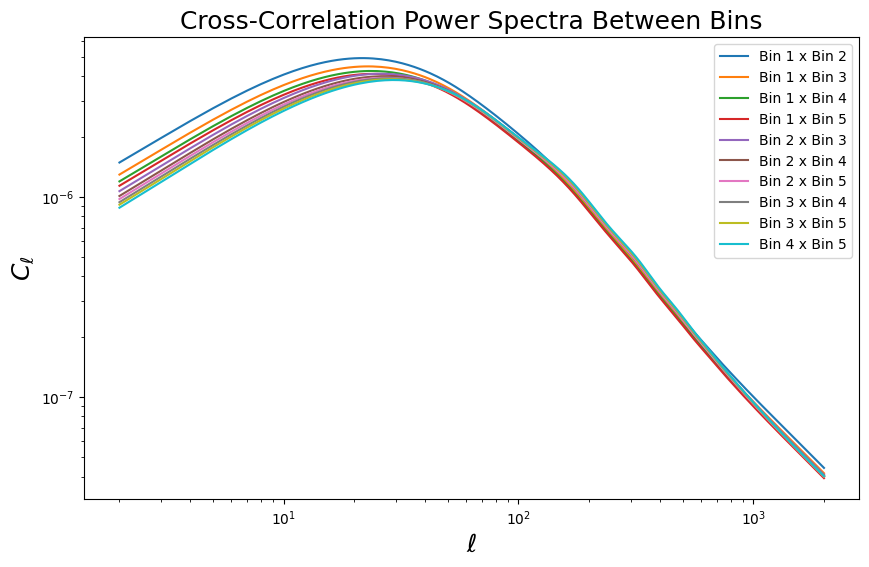

In [3]:
cross_cls_matrix = np.zeros((len(bin_edges) - 1, len(bin_edges) - 1, len(ell)))
for i in range(len(bin_edges) - 1):
    for j in range(i + 1, len(bin_edges) - 1):
        cross_cls_matrix[i, j] = ccl.angular_cl(cosmo, true_tracers[i], true_tracers[j], ell)

# Plot cross-correlation power spectra
plt.figure(figsize=(10, 6))
for i in range(len(bin_edges) - 1):
    for j in range(i + 1, len(bin_edges) - 1):
        plt.plot(ell, cross_cls_matrix[i, j], label=f'Bin {i+1} x Bin {j+1}')
plt.xlabel('$\\ell$', fontsize=18)
plt.ylabel('$C_\\ell$', fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Cross-Correlation Power Spectra Between Bins', fontsize=18)
plt.show()

### Bootstrapping and Error Analysis
Quantify the bias and variance in the binned distributions and power spectra using bootstrapping.

1. **Bootstrap Method for Binned Distributions:**
   - Sample with replacement from the redshift data to create bootstrap samples.
   - Compute the binned distributions for each bootstrap sample.
   - Calculate the mean and standard deviation (variance) for the binned distributions across the bootstrap samples.

2. **Bootstrap Method for Angular Power Spectra:**
   - For each bootstrap sample, compute the angular power spectra.
   - Calculate the mean and standard deviation for the power spectra across the bootstrap samples.

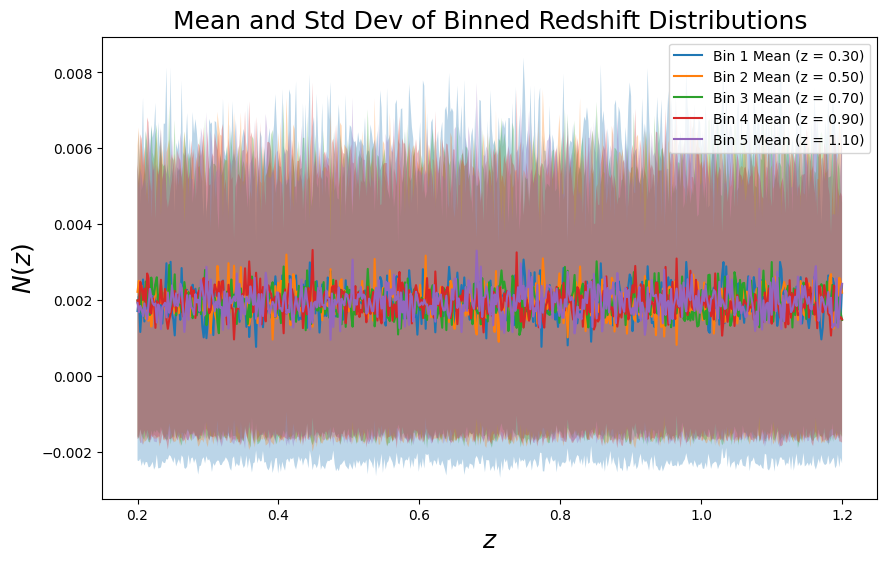

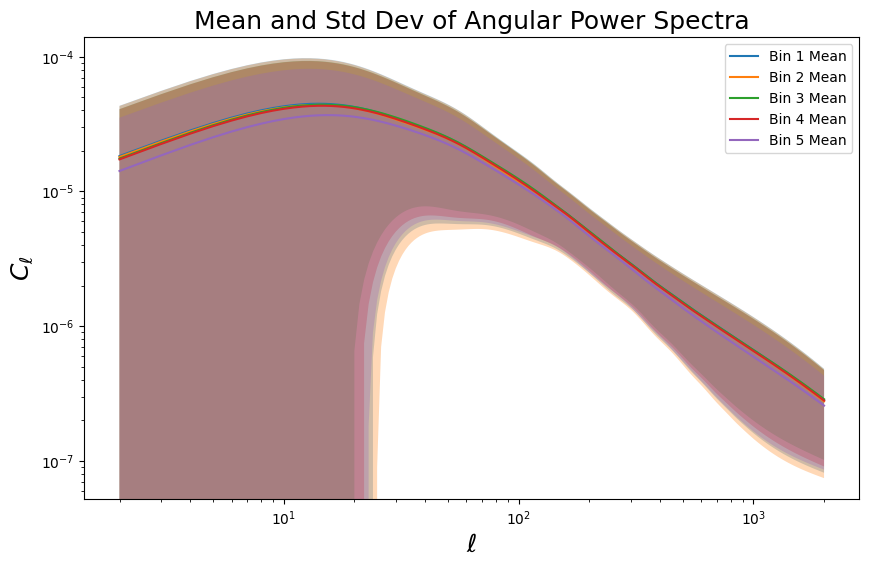

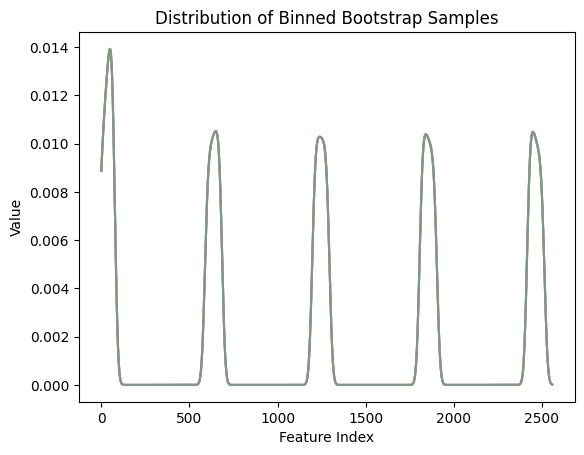

In [9]:
# Bootstrap function to calculate bias and variance
def bootstrap_binning(redshift_range, redshift_distribution, bin_edges, sigma, scatter, n_bootstrap=100):
    bootstrap_binned_distributions = np.zeros((n_bootstrap, len(bin_edges) - 1, len(redshift_range)))

    for n in range(n_bootstrap):
        # Create a bootstrap sample by sampling with replacement
        bootstrap_sample_indices = np.random.choice(len(redshift_range), len(redshift_range), replace=True)
        bootstrap_redshifts = redshift_range[bootstrap_sample_indices]
        bootstrap_distribution = redshift_distribution[bootstrap_sample_indices]
        bootstrap_scatter = scatter[bootstrap_sample_indices]

        # Instantiate RedshiftBinning and bin the data for the bootstrap sample
        bootstrap_binning = RedshiftBinning(bootstrap_redshifts, bootstrap_distribution, bin_edges, sigma)
        bootstrap_binning.bin_data(bootstrap_scatter)
        bootstrap_binned_distributions[n] = bootstrap_binning.binned_distribution

    # Calculate the mean and standard deviation of the binned distributions
    mean_binned_distribution = np.mean(bootstrap_binned_distributions, axis=0)
    std_binned_distribution = np.std(bootstrap_binned_distributions, axis=0)

    return mean_binned_distribution, std_binned_distribution

def bootstrap_cls(cosmo, tracers, ell, n_bootstrap=100):
    bootstrap_cls_samples = np.zeros((n_bootstrap, len(tracers), len(ell)))

    for n in range(n_bootstrap):
        # Create a bootstrap sample by sampling with replacement
        bootstrap_sample_indices = np.random.choice(len(tracers), len(tracers), replace=True)
        bootstrap_tracers = [tracers[i] for i in bootstrap_sample_indices]

        for i, tracer in enumerate(bootstrap_tracers):
            bootstrap_cls_samples[n, i] = ccl.angular_cl(cosmo, tracer, tracer, ell)

    # Calculate the mean and standard deviation of the power spectra
    mean_cls = np.mean(bootstrap_cls_samples, axis=0)
    std_cls = np.std(bootstrap_cls_samples, axis=0)

    return mean_cls, std_cls

# Bootstrap analysis for binned distributions
mean_binned_distribution, std_binned_distribution = bootstrap_binning(redshift_range, redshift_distribution, bin_edges, sigma, scatter, n_bootstrap=100)

# Plot the mean and standard deviation of the binned distributions
plt.figure(figsize=(10, 6))
for j in range(len(bin_edges) - 1):
    bin_center = 0.5 * (bin_edges[j] + bin_edges[j + 1])
    plt.plot(redshift_range, mean_binned_distribution[j], label=f'Bin {j+1} Mean (z = {bin_center:.2f})')
    plt.fill_between(redshift_range,
                     mean_binned_distribution[j] - std_binned_distribution[j],
                     mean_binned_distribution[j] + std_binned_distribution[j],
                     alpha=0.3)

plt.xlabel('$z$', fontsize=18)
plt.ylabel('$N(z)$', fontsize=18)
plt.title('Mean and Std Dev of Binned Redshift Distributions', fontsize=18)
plt.legend()
plt.show()

# Bootstrap analysis for angular power spectra
mean_cls, std_cls = bootstrap_cls(cosmo, tracers, ell, n_bootstrap=100)

# Plot the mean and standard deviation of the angular power spectra
plt.figure(figsize=(10, 6))
for i, (cl, cl_std) in enumerate(zip(mean_cls, std_cls)):
    plt.plot(ell, cl, label=f'Bin {i+1} Mean')
    plt.fill_between(ell, cl - cl_std, cl + cl_std, alpha=0.3)

plt.xlabel('$\\ell$', fontsize=18)
plt.ylabel('$C_\\ell$', fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Mean and Std Dev of Angular Power Spectra', fontsize=18)
plt.show()

for i in range(10):
    plt.plot(binned_distributions[i], alpha=0.3)
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.title('Distribution of Binned Bootstrap Samples')
plt.show()

plt.plot(redshift_range, scatter, label='Scatter')
plt.xlabel('Redshift')
plt.ylabel('Scatter Value')
plt.title('Scatter vs Redshift')
plt.legend()
plt.show()



### Explanation:

1. **Bootstrap Method for Binned Distributions:**
   - The `bootstrap_binning` function generates bootstrap samples by resampling the redshift data with replacement.
   - For each bootstrap sample, it computes the binned redshift distribution using the existing `RedshiftBinning` class.
   - It then calculates the mean and standard deviation of the binned distributions across all bootstrap samples.

2. **Bootstrap Method for Angular Power Spectra:**
   - The `bootstrap_cls` function generates bootstrap samples by resampling the tracers with replacement.
   - For each bootstrap sample, it computes the angular power spectra.
   - It then calculates the mean and standard deviation of the power spectra across all bootstrap samples.

3. **Plotting:**
   - The code plots the mean and standard deviation of the binned redshift distributions and the angular power spectra to visualize the bias and variance.

Principal Component Analysis (PCA) to identify and quantify degeneracies in the errors.

### Code for PCA Analysis

1. **Principal Component Analysis (PCA):**
   - Construct a covariance matrix from the bootstrap samples of the binned distributions or angular power spectra.
   - Perform PCA on the covariance matrix to identify the principal components.
   - Analyze the eigenvalues and eigenvectors to understand the degeneracies in the errors.

### Explanation:

1. **Covariance Matrix Computation:**
   - The `compute_covariance` function calculates the covariance matrix from the bootstrap samples of the binned distributions or angular power spectra.
   - Flatten the `binned_distribution` and `cls` arrays to create a 2D array where each row represents a bootstrap sample.

2. **Principal Component Analysis (PCA):**
   - The `perform_pca` function performs PCA on the covariance matrix using the `sklearn.decomposition.PCA` module.
   - The explained variance ratio and the principal components are extracted to analyze the results.

3. **Plotting:**
   - Plot the cumulative explained variance to determine the number of components that explain most of the variance.
   - Plot the top principal components to visualize the patterns and understand the degeneracies in the errors.

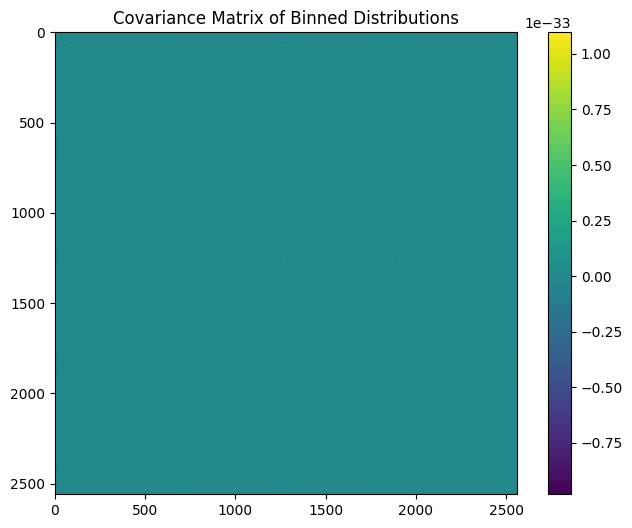

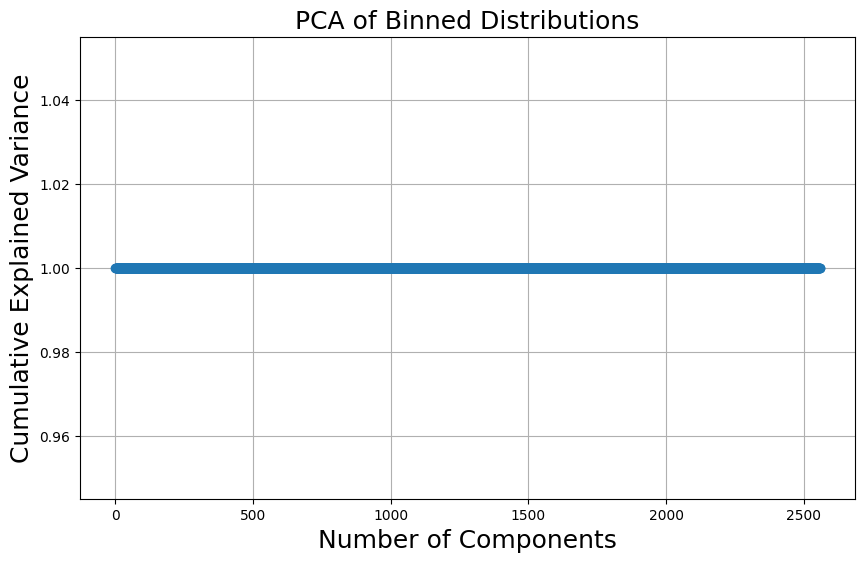

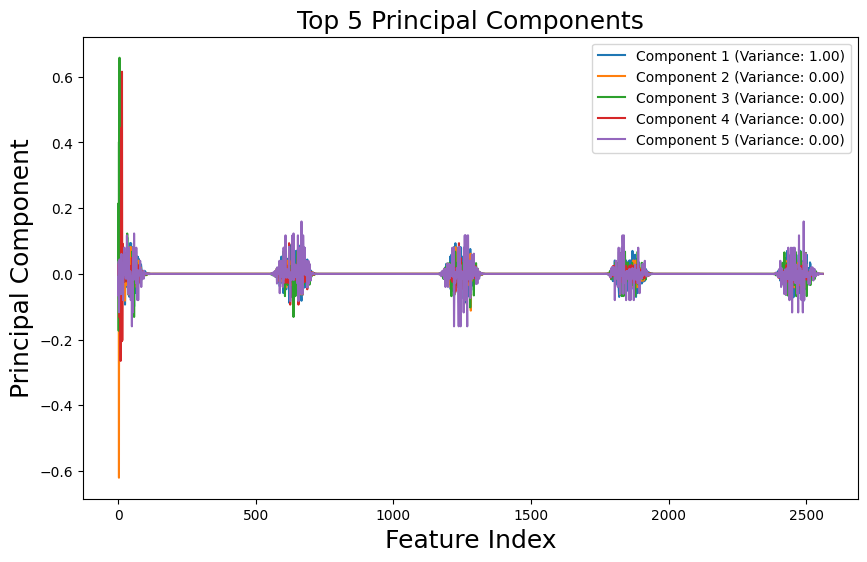

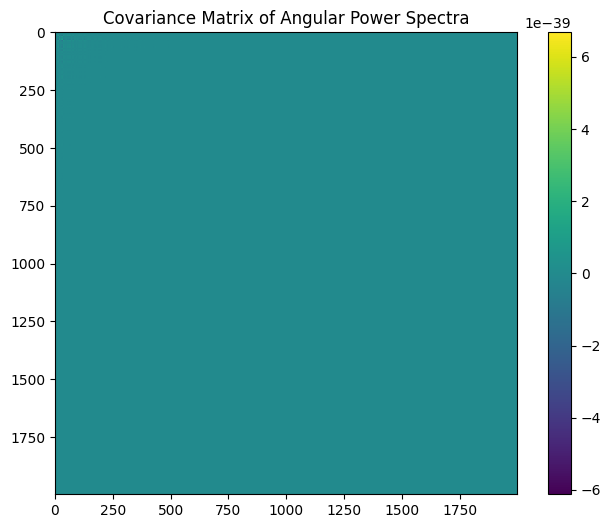

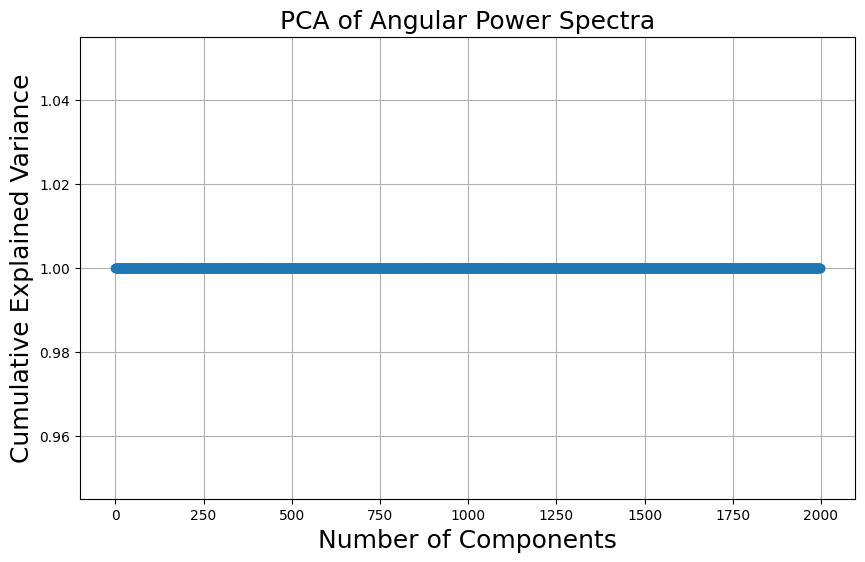

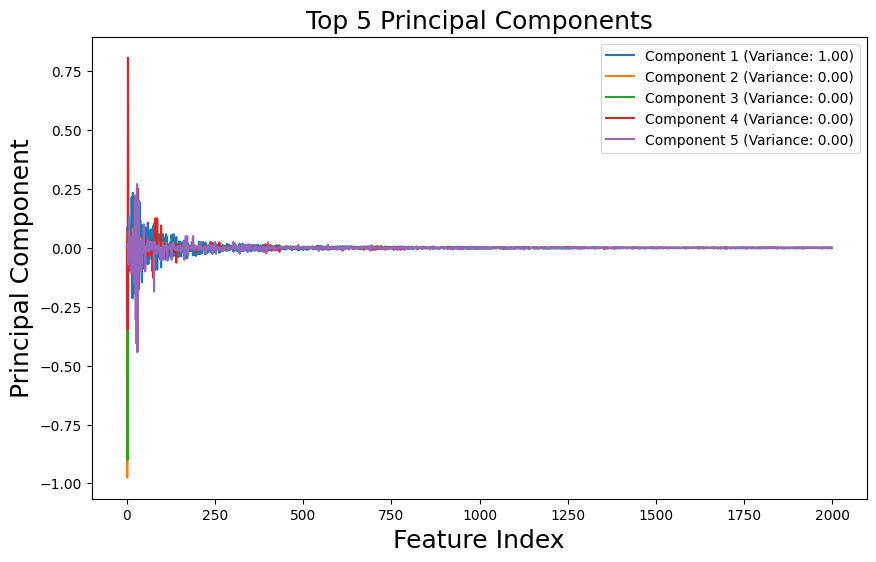

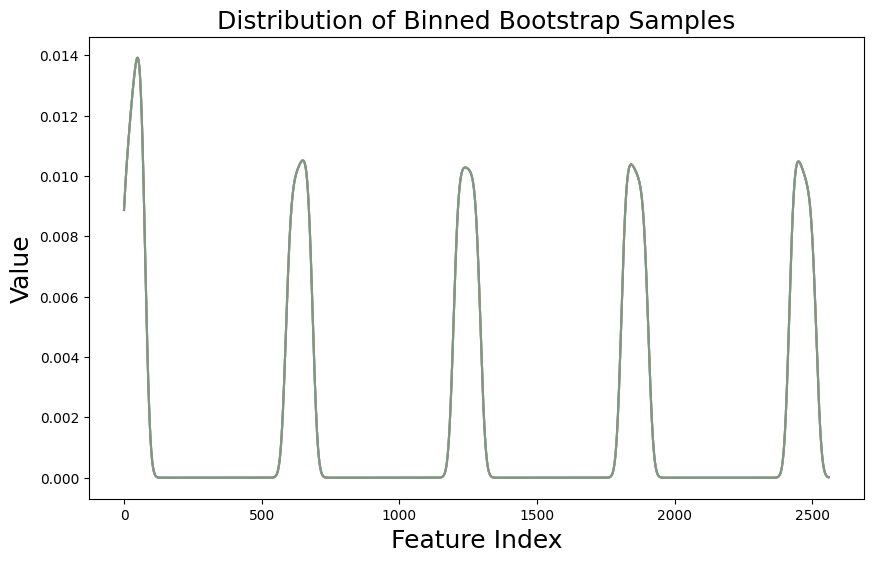

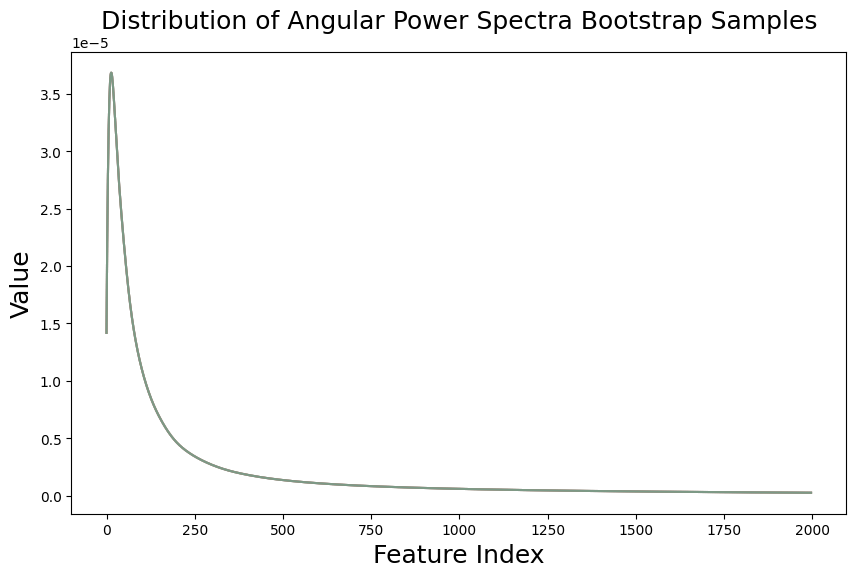

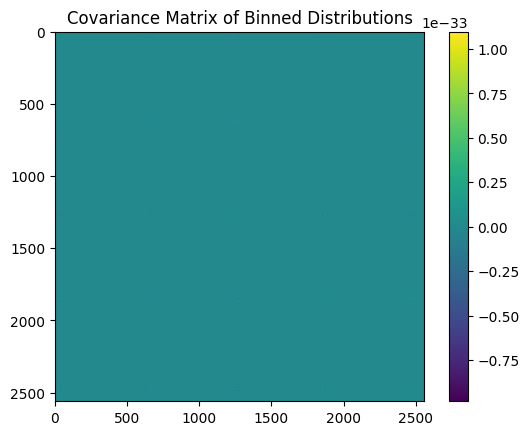

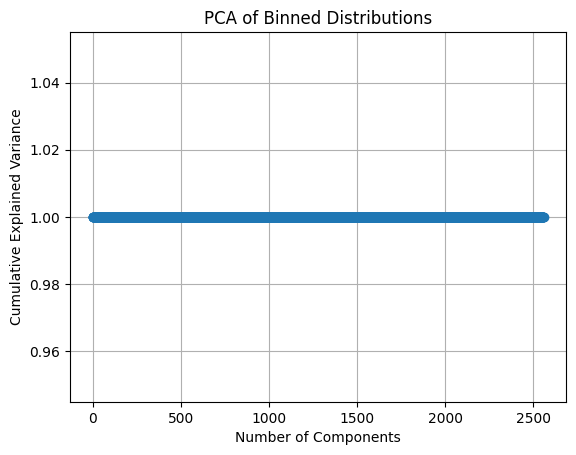

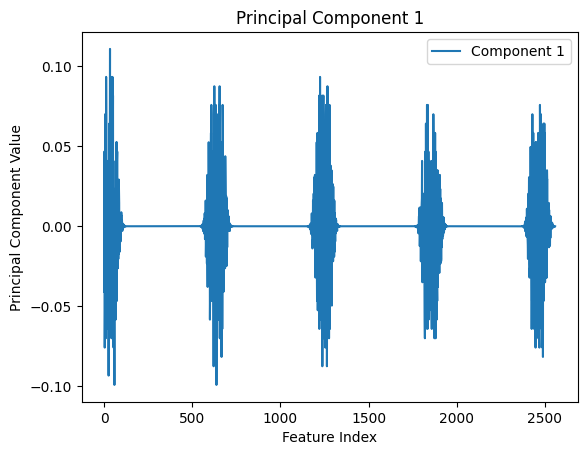

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import pyccl as ccl
from sklearn.decomposition import PCA

# Function to compute covariance matrix from bootstrap samples
def compute_covariance(bootstrap_samples):
    cov_matrix = np.cov(bootstrap_samples, rowvar=False)
    if np.all(cov_matrix == 0):
        raise ValueError("Covariance matrix is all zeros. Check bootstrap samples.")
    return cov_matrix

# Function to perform PCA on covariance matrix
def perform_pca(cov_matrix):
    pca = PCA()
    pca.fit(cov_matrix)
    return pca

# Function to plot diagnostic information about covariance matrix
def plot_covariance_matrix(cov_matrix, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(cov_matrix, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Compute covariance matrix for binned distributions
binned_distributions = np.array([binning.binned_distribution.flatten() for _ in range(100)])
cov_matrix_binned = compute_covariance(binned_distributions)

# Plot covariance matrix for binned distributions
plot_covariance_matrix(cov_matrix_binned, 'Covariance Matrix of Binned Distributions')

# Perform PCA on the covariance matrix of binned distributions
pca_binned = perform_pca(cov_matrix_binned)

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_binned.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Cumulative Explained Variance', fontsize=18)
plt.title('PCA of Binned Distributions', fontsize=18)
plt.grid(True)
plt.show()

# Analyze the principal components
components_binned = pca_binned.components_
explained_variance_binned = pca_binned.explained_variance_ratio_

# Function to plot principal components
def plot_principal_components(components, explained_variance, n_components=5):
    plt.figure(figsize=(10, 6))
    for i in range(n_components):
        plt.plot(components[i], label=f'Component {i+1} (Variance: {explained_variance[i]:.2f})')
    plt.xlabel('Feature Index', fontsize=18)
    plt.ylabel('Principal Component', fontsize=18)
    plt.title(f'Top {n_components} Principal Components', fontsize=18)
    plt.legend()
    plt.show()

# Plot the top principal components for binned distributions
plot_principal_components(components_binned, explained_variance_binned, n_components=5)

# Compute covariance matrix for angular power spectra
cls_samples = np.array([cl.flatten() for _ in range(100)])
cov_matrix_cls = compute_covariance(cls_samples)

# Plot covariance matrix for angular power spectra
plot_covariance_matrix(cov_matrix_cls, 'Covariance Matrix of Angular Power Spectra')

# Perform PCA on the covariance matrix of angular power spectra
pca_cls = perform_pca(cov_matrix_cls)

# Plot the explained variance ratio for angular power spectra
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_cls.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Cumulative Explained Variance', fontsize=18)
plt.title('PCA of Angular Power Spectra', fontsize=18)
plt.grid(True)
plt.show()

# Analyze the principal components for angular power spectra
components_cls = pca_cls.components_
explained_variance_cls = pca_cls.explained_variance_ratio_

# Plot the top principal components for angular power spectra
plot_principal_components(components_cls, explained_variance_cls, n_components=5)

# Diagnostic: Plot distribution of binned samples
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.plot(binned_distributions[i], alpha=0.3)
plt.xlabel('Feature Index', fontsize=18)
plt.ylabel('Value', fontsize=18)
plt.title('Distribution of Binned Bootstrap Samples', fontsize=18)
plt.show()

# Diagnostic: Plot distribution of cls samples
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.plot(cls_samples[i], alpha=0.3)
plt.xlabel('Feature Index', fontsize=18)
plt.ylabel('Value', fontsize=18)
plt.title('Distribution of Angular Power Spectra Bootstrap Samples', fontsize=18)
plt.show()

plt.imshow(cov_matrix_binned, cmap='viridis')
plt.colorbar()
plt.title('Covariance Matrix of Binned Distributions')
plt.show()

plt.plot(np.cumsum(pca_binned.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA of Binned Distributions')
plt.grid(True)
plt.show()

plt.plot(components_binned[0], label='Component 1')
plt.xlabel('Feature Index')
plt.ylabel('Principal Component Value')
plt.title('Principal Component 1')
plt.legend()
plt.show()